 ## 数据源介绍
 本次实验使用的是 UCI Machine Learning Repository 公开的 iris 鸢尾花数据

 其中数据区（data）含有样本数 150 ，特征 4 个：萼片长度（sepal length (cm)）、萼片宽度（sepal width (cm)）、花瓣长度（petal length (cm)）、花瓣宽度（petal width (cm)）

 花的类型（target）为 setosa、versicolor、virginica，分别标记为 0、1、2

 ## 1、初始化

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)

 ## 2、平行坐标多维显示
 由于每一朵花的实例都有 4 个属性，因此可以用平行坐标法的折线来表示

 可以发现，展示结果中有两种花的折线图走势非常相近，而第三种的差异较大

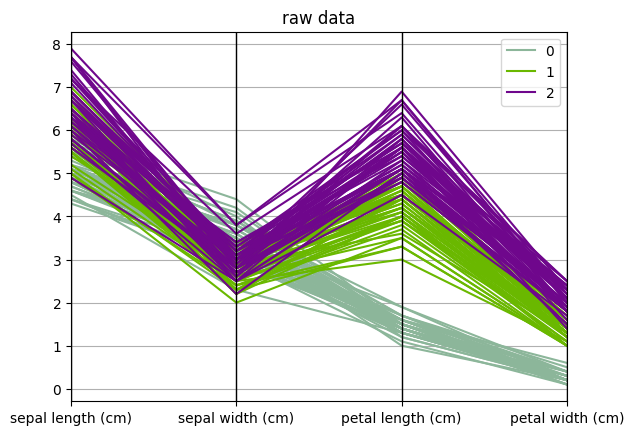

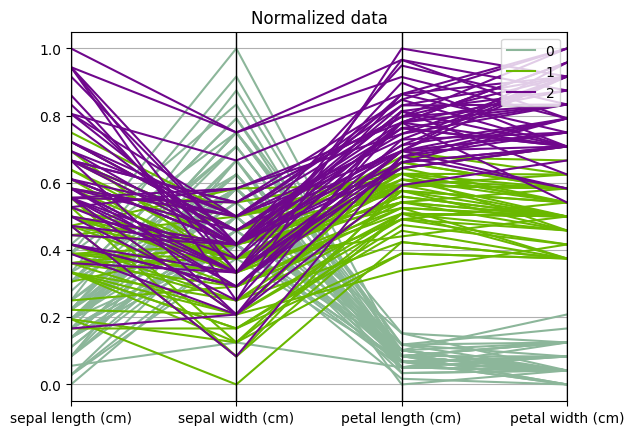

In [2]:
from pandas.plotting import parallel_coordinates

parallel_coordinates(iris.frame,'target')
plt.title('raw data')
plt.show()

std = iris.frame.iloc[:,:-1]
std = (std - std.min())/(std.max() - std.min())
std = pd.concat([std,pd.DataFrame(iris.frame['target'])],axis=1)

parallel_coordinates(std,'target')
plt.title('Normalized data')
plt.show()

 ## 3、特征选择

 使用 PCA 提取 2 个特征并显示

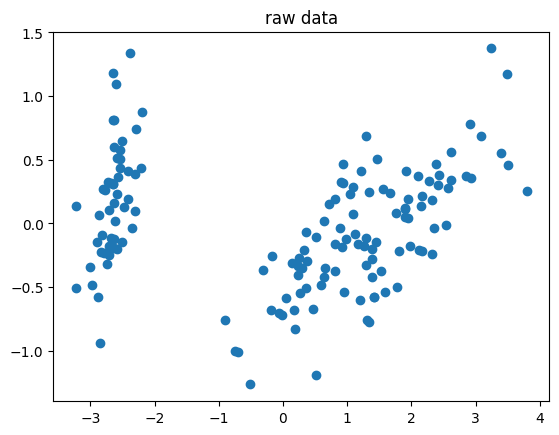

pca ratio: [0.92461872 0.05306648]


In [3]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X = pca.fit_transform(iris.data.values)
dataPca = pd.DataFrame()
dataPca['X'] = X[:,0]
dataPca['Y'] = X[:,1]

plt.scatter(dataPca['X'], dataPca['Y'])
plt.title('raw data')
plt.show()
print('pca ratio:', pca.explained_variance_ratio_)

 ## 4、K-Means聚类

 调用 sklearn 的 kmeans 方法对所有数据聚 3 类，并得到评价结果

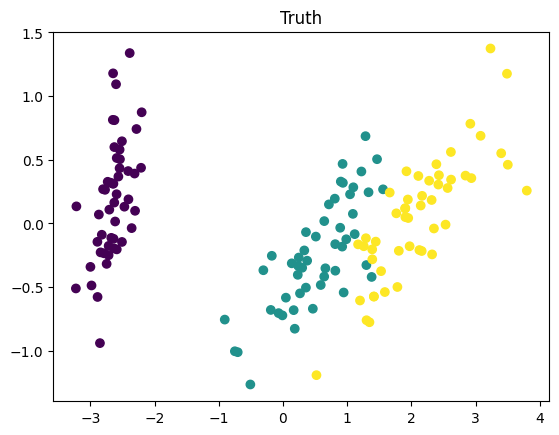

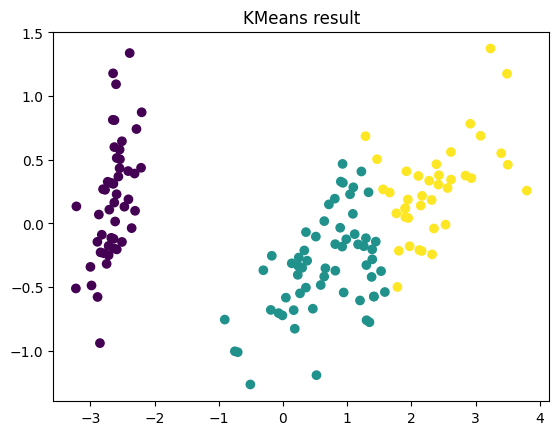


KMeans confusion matrix:
[[50  0  0]
 [ 0 47  3]
 [ 0 14 36]]

KMeans classification report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        50
  versicolor       0.77      0.94      0.85        50
   virginica       0.92      0.72      0.81        50

    accuracy                           0.89       150
   macro avg       0.90      0.89      0.89       150
weighted avg       0.90      0.89      0.89       150



In [4]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 3, n_init='auto')
kmeans.fit(iris.data.values, iris.target.values)
dataPca['kmeans'] = kmeans.predict(iris.data.values)


def classResultAdjust(array):
    temp=list(array)
    a=set(temp)
    mat=[[0,0,i] for i in range(len(a))]
    for i,j in enumerate(temp):
        mat[j][0] += i
        mat[j][1] += 1
    for i in range(len(a)):
        mat[i][0] /= mat[i][1]
    mat.sort()
    index = 0
    dic={}
    for i in mat:
        dic[i[2]]=index
        index += 1
    temp1 = [0 for i in range(len(temp))]
    for i,j in enumerate(temp):
        temp1[i] = dic[j]
    return temp1
dataPca['kmeans'] = classResultAdjust(dataPca['kmeans'])


plt.scatter(dataPca['X'], dataPca['Y'], c=iris.target.values)
plt.title("Truth")
plt.show()
plt.scatter(dataPca['X'], dataPca['Y'], c=dataPca['kmeans'])
plt.title("KMeans result")
plt.show()

print('\nKMeans confusion matrix:')
print(metrics.confusion_matrix(iris.target.values, dataPca['kmeans']))
print('\nKMeans classification report:')
print(metrics.classification_report(iris.target.values, dataPca['kmeans'], target_names = iris.target_names))

## 5、机器学习分类

与 kmeans 非监督聚类不同的是，MLModel 使用多元线性回归对 iris 数据集进行训练

In [5]:
import numpy as np
from sklearn.metrics import accuracy_score

class MLModel():

    def __init__(self, dim, target_num):
        self.target_num = target_num
        self.w = np.zeros((dim, 1))
        self.b = 0.0

    def forward(self, x):
        x = x @ self.w + self.b
        x = self.sigmoid(x)
        return x

    def sigmoid(self, x):
        x = 1 / (1 + np.exp(-x))
        return x

    def group(self, x):
        x = x.reshape(-1)
        x *= self.target_num
        x -= 0.5
        return np.round(x)

    def train(self, x, y, lr):
        s = self.forward(x)
        loss = -np.mean(y * np.log(s) + (1 - y) * np.log(1 - s))
        dw = (x.T @ (s - y)) / x.shape[0]
        db = np.mean(s - y)
        self.w -= lr * dw
        self.b -= lr * db
        return loss

    def fit(self, x_train, y_train, x_eval, y_eval, print_loss=False, epochs=100, lr=1):
        x_train_standard = (x_train - x_train.min()) / (x_train.max() - x_train.min())
        y_train = y_train.reshape(-1, 1)
        y_train_standard = (y_train - y_train.min()) / (y_train.max() - y_train.min())

        x_eval_standard = (x_eval - x_eval.min()) / (x_eval.max() - x_eval.min())
        y_eval = y_eval.reshape(-1, 1)
        y_eval_standard = (y_eval - y_eval.min()) / (y_eval.max() - y_eval.min())

        for epoch in range(epochs):
            loss_train = self.train(x_train_standard, y_train_standard, lr)
            pred_train = self.predict(x_train)
            pred_eval = self.predict(x_eval)
            acc_train = accuracy_score(y_train, pred_train)
            acc_eval = accuracy_score(y_eval, pred_eval)
            if print_loss and (epoch + 1) % 10 == 0:
                print(f'epoch: {(epoch+1):03d} '+
                    f'loss_train: {loss_train:.4f} '+
                    f'acc_train: {acc_train:.4f} '+
                    f'acc_eval: {acc_eval:.4f}')

    def predict(self, x: np.ndarray):
        x_flatten = (x - x.min()) / (x.max() - x.min())
        pred = self.group(self.forward(x_flatten))
        return pred


In [6]:
def train_eval_test_split(x, y, train_size, test_size):
    idx = np.arange(len(x))
    np.random.shuffle(idx)
    train_num = round(len(x) * train_size)
    test_num = round(len(x) * test_size)
    eval_num = len(x) - train_num - test_num
    x_train, y_train = x[idx[:train_num]], y[idx[:train_num]]
    x_eval, y_eval = x[idx[train_num: train_num + eval_num]], y[idx[train_num: train_num + eval_num]]
    x_test, y_test = x[idx[-test_num:]], y[idx[-test_num:]]
    return x_train, y_train, x_eval, y_eval, x_test, y_test

In [7]:
train_size = 0.4
test_size = 0.3
x_train, y_train, x_eval, y_eval, x_test, y_test = \
    train_eval_test_split(iris.data.values, iris.target.values, train_size, test_size)

epoch: 010 loss_train: 0.6332 acc_train: 0.3500 acc_eval: 0.3111
epoch: 020 loss_train: 0.5819 acc_train: 0.3500 acc_eval: 0.3111
epoch: 030 loss_train: 0.5417 acc_train: 0.4167 acc_eval: 0.4000
epoch: 040 loss_train: 0.5099 acc_train: 0.7333 acc_eval: 0.8444
epoch: 050 loss_train: 0.4844 acc_train: 0.8667 acc_eval: 0.9333
epoch: 060 loss_train: 0.4637 acc_train: 0.9167 acc_eval: 0.9778
epoch: 070 loss_train: 0.4466 acc_train: 0.9667 acc_eval: 0.9556
epoch: 080 loss_train: 0.4324 acc_train: 0.9500 acc_eval: 0.9556
epoch: 090 loss_train: 0.4205 acc_train: 0.9333 acc_eval: 0.9778
epoch: 100 loss_train: 0.4104 acc_train: 0.9500 acc_eval: 0.9778


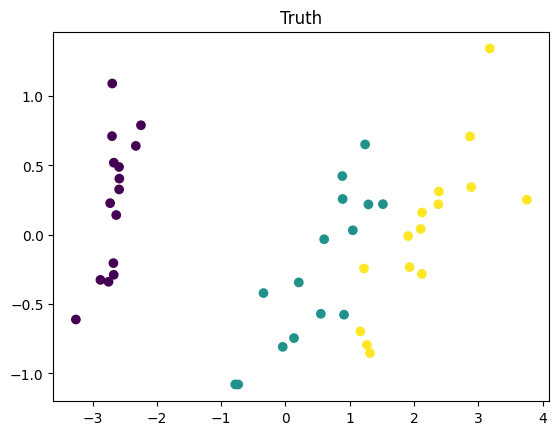

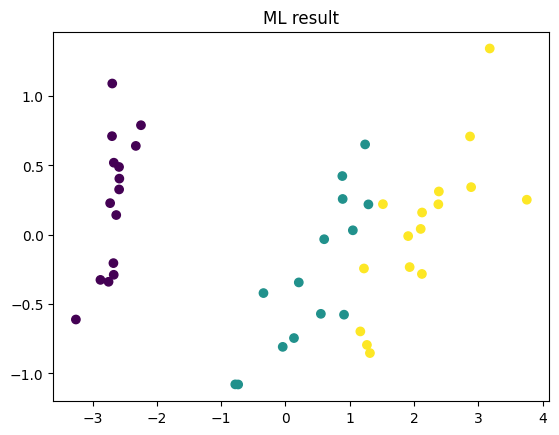


test size: 0.3

acc_test: 0.9778

ML confusion matrix:
[[15  0  0]
 [ 0 14  1]
 [ 0  0 15]]

ML classification report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       1.00      0.93      0.97        15
   virginica       0.94      1.00      0.97        15

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



In [8]:
mlModel = MLModel(dim=iris.data.values.shape[1], target_num=len(iris.target_names))
mlModel.fit(x_train, y_train, x_eval, y_eval, print_loss=True, epochs=100, lr=1)
pred_test = mlModel.predict(x_test)
pca = PCA(n_components=2)
coo = pca.fit_transform(x_test)

plt.scatter(coo[:, 0], coo[:, 1], c=y_test)
plt.title("Truth")
plt.show()
plt.scatter(coo[:, 0], coo[:, 1], c=pred_test)
plt.title("ML result")
plt.show()

print(f'\ntest size: {test_size}')
print(f'\nacc_test: {accuracy_score(y_test, pred_test):.4f}')
print('\nML confusion matrix:')
print(metrics.confusion_matrix(y_test, pred_test))
print('\nML classification report:')
print(metrics.classification_report(y_test, pred_test, target_names = iris.target_names))